In [247]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense

import cv2
import pandas as pd
import dlib

In [251]:
for i in range(500):
    globals()['land'+str(i)] = pd.read_csv('./dlib500/train/%s.csv'%i)
    globals()['land'+str(i)] = np.array(globals()['land'+str(i)])
    
    tr_x = globals()['land'+str(i)][:, 0]
    tr_y = globals()['land'+str(i)][:, 1]
    
    tr_cx = ((min(tr_x)+max(tr_x)) / 2)        #dlib_rect 중점
    tr_cy = ((min(tr_y)+max(tr_y)) / 2)
    
    tr_h = max(tr_y)-min(tr_y)    #종축 길이
    
    tr_x -= tr_cx
    tr_y -= tr_cy
    
    norm_trx = (tr_x - min(tr_x)) / (tr_h * 1.5)
    norm_try = (tr_y - min(tr_y)) / (tr_h *1.5)
    
    globals()['train_norm'+str(i)] = np.column_stack((norm_trx, norm_try))

In [252]:
## eye, nose, mouth, jaws
for i in  range(500):
    globals()['norm_eye'+str(i)] = globals()['train_norm'+str(i)][36:48].flatten()
    globals()['norm_nose'+str(i)] = globals()['train_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth'+str(i)] = globals()['train_norm'+str(i)][48:].flatten()
    globals()['norm_jaws'+str(i)] = globals()['train_norm'+str(i)][:17].flatten()

In [253]:
train_x = np.zeros((500, len(norm_eye0)))   #eye
for i in range(500):
    for j in range(len(norm_eye0)):
        train_x[i][j] = globals()['norm_eye'+str(i)][j]   

In [254]:
try_eye = pd.read_csv('./DataSet500/train/csv/train.csv')
try_eye = try_eye.iloc[:, 16]

In [255]:
for i in range(500):
    globals()['mark'+str(i)] = pd.read_csv('./dlib500/test/%s.csv'%i)
    globals()['mark'+str(i)] = np.array(globals()['mark'+str(i)])
    
    te_x = globals()['mark'+str(i)][:, 0]
    te_y = globals()['mark'+str(i)][:, 1]
    
    te_cx = ((min(te_x)+max(te_x)) / 2)
    te_cy = ((min(te_y)+max(te_y)) / 2)

    te_h = max(te_y)-min(te_y)
    
    
    te_x -= te_cx
    te_y -= te_cy

    norm_tex = (te_x - min(te_x)) / (te_h *1.5)
    norm_tey = (te_y - min(te_y)) / (te_h *1.5)
    
    globals()['test_norm'+str(i)] = np.column_stack((norm_tex, norm_tey))

In [256]:
## eye, nose, mouth, jaws
for i in  range(500):
    globals()['norm_eye2'+str(i)] = globals()['test_norm'+str(i)][36:48].flatten()
    globals()['norm_nose2'+str(i)] = globals()['test_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth2'+str(i)] = globals()['test_norm'+str(i)][48:].flatten()
    globals()['norm_jaws2'+str(i)] = globals()['test_norm'+str(i)][:17].flatten()

In [257]:
test_x = np.zeros((500, len(norm_eye20)))
for i in range(500):
    for j in range(len(norm_eye20)):
        test_x[i][j] = globals()['norm_eye2'+str(i)][j]  

In [258]:
tey_eye = pd.read_csv('./DataSet500/test/csv/test.csv')
tey_eye = tey_eye.iloc[:, 16]

In [259]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, try_eye))\
                                .shuffle(500)\
                                .batch(N_BATCH, drop_remainder=True)\
                                .repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, tey_eye)).batch(N_BATCH)

In [282]:
np.random.seed(1)
tf.random.set_seed(1)

learning_rate = 0.0005
N_EPOCHS = 500
N_BATCH = 32

In [261]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=16, activation='relu', input_shape=(24,)))
    model.add(keras.layers.Dense(units=8, activation='relu'))
    model.add(keras.layers.Dense(units=4, activation='relu'))
    model.add(keras.layers.Dense(units=1))
    
    return model

In [283]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [284]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 16)                400       
                                                                 
 dense_73 (Dense)            (None, 8)                 136       
                                                                 
 dense_74 (Dense)            (None, 4)                 36        
                                                                 
 dense_75 (Dense)            (None, 1)                 5         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [285]:
steps_per_epoch = train_x.shape[0]
validation_steps = int(np.ceil(test_x.shape[0]/N_BATCH))

In [286]:
history = model.fit(train_dataset,
                   epochs=N_EPOCHS,
                   steps_per_epoch=steps_per_epoch,
                   validation_data = test_dataset,
                   validation_steps = validation_steps)

Epoch 1/500
500/500 [==============================] - 1s 699us/step - loss: 0.0850 - val_loss: 0.0811
Epoch 2/500
500/500 [==============================] - 0s 595us/step - loss: 0.0772 - val_loss: 0.0689
Epoch 3/500
500/500 [==============================] - 0s 595us/step - loss: 0.0597 - val_loss: 0.0470
Epoch 4/500
500/500 [==============================] - 0s 593us/step - loss: 0.0377 - val_loss: 0.0334
Epoch 5/500
500/500 [==============================] - 0s 595us/step - loss: 0.0292 - val_loss: 0.0285
Epoch 6/500
500/500 [==============================] - 0s 596us/step - loss: 0.0267 - val_loss: 0.0258
Epoch 7/500
500/500 [==============================] - 0s 595us/step - loss: 0.0258 - val_loss: 0.0249
Epoch 8/500
500/500 [==============================] - 0s 613us/step - loss: 0.0251 - val_loss: 0.0242
Epoch 9/500
500/500 [==============================] - 0s 607us/step - loss: 0.0248 - val_loss: 0.0236
Epoch 10/500
500/500 [==============================] - 0s 633us/step - l

Epoch 80/500
500/500 [==============================] - 0s 591us/step - loss: 0.0195 - val_loss: 0.0202
Epoch 81/500
500/500 [==============================] - 0s 591us/step - loss: 0.0195 - val_loss: 0.0176
Epoch 82/500
500/500 [==============================] - 0s 591us/step - loss: 0.0193 - val_loss: 0.0176
Epoch 83/500
500/500 [==============================] - 0s 591us/step - loss: 0.0193 - val_loss: 0.0182
Epoch 84/500
500/500 [==============================] - 0s 595us/step - loss: 0.0191 - val_loss: 0.0182
Epoch 85/500
500/500 [==============================] - 0s 601us/step - loss: 0.0192 - val_loss: 0.0185
Epoch 86/500
500/500 [==============================] - 0s 603us/step - loss: 0.0192 - val_loss: 0.0175
Epoch 87/500
500/500 [==============================] - 0s 597us/step - loss: 0.0192 - val_loss: 0.0174
Epoch 88/500
500/500 [==============================] - 0s 603us/step - loss: 0.0196 - val_loss: 0.0174
Epoch 89/500
500/500 [==============================] - 0s 593us

500/500 [==============================] - 0s 601us/step - loss: 0.0185 - val_loss: 0.0205
Epoch 159/500
500/500 [==============================] - 0s 597us/step - loss: 0.0182 - val_loss: 0.0170
Epoch 160/500
500/500 [==============================] - 0s 597us/step - loss: 0.0181 - val_loss: 0.0172
Epoch 161/500
500/500 [==============================] - 0s 607us/step - loss: 0.0182 - val_loss: 0.0170
Epoch 162/500
500/500 [==============================] - 0s 593us/step - loss: 0.0184 - val_loss: 0.0167
Epoch 163/500
500/500 [==============================] - 0s 601us/step - loss: 0.0184 - val_loss: 0.0169
Epoch 164/500
500/500 [==============================] - 0s 595us/step - loss: 0.0182 - val_loss: 0.0179
Epoch 165/500
500/500 [==============================] - 0s 595us/step - loss: 0.0182 - val_loss: 0.0168
Epoch 166/500
500/500 [==============================] - 0s 593us/step - loss: 0.0182 - val_loss: 0.0167
Epoch 167/500
500/500 [==============================] - 0s 611us/ste

500/500 [==============================] - 0s 613us/step - loss: 0.0174 - val_loss: 0.0167
Epoch 237/500
500/500 [==============================] - 0s 601us/step - loss: 0.0179 - val_loss: 0.0169
Epoch 238/500
500/500 [==============================] - 0s 597us/step - loss: 0.0177 - val_loss: 0.0176
Epoch 239/500
500/500 [==============================] - 0s 599us/step - loss: 0.0174 - val_loss: 0.0168
Epoch 240/500
500/500 [==============================] - 0s 599us/step - loss: 0.0177 - val_loss: 0.0169
Epoch 241/500
500/500 [==============================] - 0s 597us/step - loss: 0.0176 - val_loss: 0.0166
Epoch 242/500
500/500 [==============================] - 0s 593us/step - loss: 0.0176 - val_loss: 0.0164
Epoch 243/500
500/500 [==============================] - 0s 596us/step - loss: 0.0176 - val_loss: 0.0171
Epoch 244/500
500/500 [==============================] - 0s 593us/step - loss: 0.0177 - val_loss: 0.0175
Epoch 245/500
500/500 [==============================] - 0s 597us/ste

500/500 [==============================] - 0s 599us/step - loss: 0.0169 - val_loss: 0.0159
Epoch 315/500
500/500 [==============================] - 0s 597us/step - loss: 0.0168 - val_loss: 0.0162
Epoch 316/500
500/500 [==============================] - 0s 597us/step - loss: 0.0164 - val_loss: 0.0160
Epoch 317/500
500/500 [==============================] - 0s 593us/step - loss: 0.0168 - val_loss: 0.0170
Epoch 318/500
500/500 [==============================] - 0s 593us/step - loss: 0.0176 - val_loss: 0.0156
Epoch 319/500
500/500 [==============================] - 0s 595us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 320/500
500/500 [==============================] - 0s 595us/step - loss: 0.0165 - val_loss: 0.0167
Epoch 321/500
500/500 [==============================] - 0s 603us/step - loss: 0.0163 - val_loss: 0.0154
Epoch 322/500
500/500 [==============================] - 0s 599us/step - loss: 0.0162 - val_loss: 0.0155
Epoch 323/500
500/500 [==============================] - 0s 601us/ste

500/500 [==============================] - 0s 597us/step - loss: 0.0174 - val_loss: 0.0162
Epoch 393/500
500/500 [==============================] - 0s 593us/step - loss: 0.0170 - val_loss: 0.0165
Epoch 394/500
500/500 [==============================] - 0s 595us/step - loss: 0.0171 - val_loss: 0.0165
Epoch 395/500
500/500 [==============================] - 0s 599us/step - loss: 0.0171 - val_loss: 0.0160
Epoch 396/500
500/500 [==============================] - 0s 595us/step - loss: 0.0171 - val_loss: 0.0162
Epoch 397/500
500/500 [==============================] - 0s 601us/step - loss: 0.0173 - val_loss: 0.0178
Epoch 398/500
500/500 [==============================] - 0s 607us/step - loss: 0.0171 - val_loss: 0.0163
Epoch 399/500
500/500 [==============================] - 0s 605us/step - loss: 0.0169 - val_loss: 0.0162
Epoch 400/500
500/500 [==============================] - 0s 609us/step - loss: 0.0169 - val_loss: 0.0163
Epoch 401/500
500/500 [==============================] - 0s 607us/ste

500/500 [==============================] - 0s 597us/step - loss: 0.0166 - val_loss: 0.0167
Epoch 471/500
500/500 [==============================] - 0s 595us/step - loss: 0.0169 - val_loss: 0.0156
Epoch 472/500
500/500 [==============================] - 0s 591us/step - loss: 0.0165 - val_loss: 0.0156
Epoch 473/500
500/500 [==============================] - 0s 615us/step - loss: 0.0167 - val_loss: 0.0158
Epoch 474/500
500/500 [==============================] - 0s 595us/step - loss: 0.0167 - val_loss: 0.0157
Epoch 475/500
500/500 [==============================] - 0s 601us/step - loss: 0.0166 - val_loss: 0.0157
Epoch 476/500
500/500 [==============================] - 0s 595us/step - loss: 0.0166 - val_loss: 0.0157
Epoch 477/500
500/500 [==============================] - 0s 601us/step - loss: 0.0166 - val_loss: 0.0155
Epoch 478/500
500/500 [==============================] - 0s 597us/step - loss: 0.0165 - val_loss: 0.0164
Epoch 479/500
500/500 [==============================] - 0s 603us/ste

In [287]:
model.evaluate(test_dataset)

history.history.keys()

16/16 [==============================] - 0s 600us/step - loss: 0.0152


dict_keys(['loss', 'val_loss'])

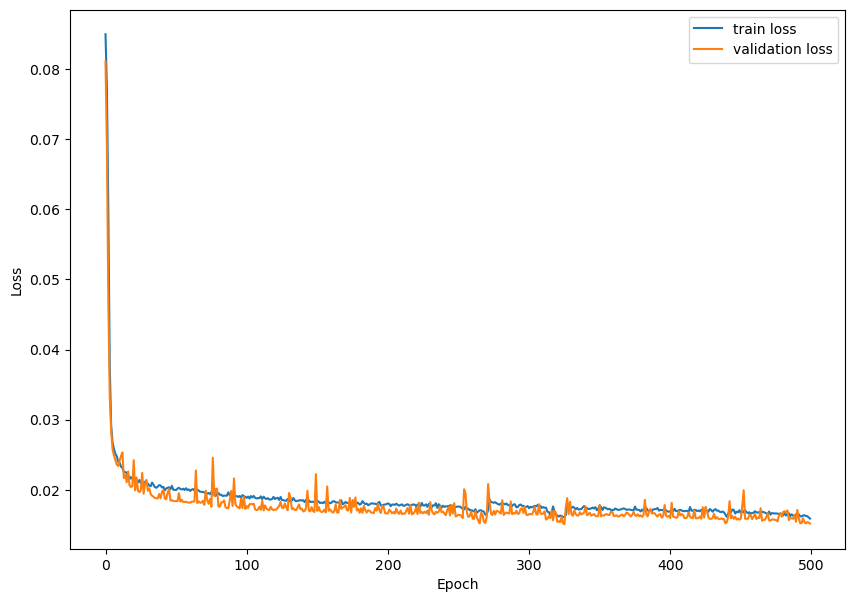

In [288]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [289]:
pred = model.predict(test_x)
df = pd.DataFrame(pred)
df

16/16 [==============================] - 0s 533us/step


,0
0,0.774298
1,0.468265
2,0.055020
3,0.341605
4,0.516595
...,...
495,0.602777
496,0.404486
497,0.249199
498,0.894634


In [290]:
tey_eye

0      0.755735
1      0.508053
2      0.133663
3      0.162626
4      0.692402
         ...   
495    0.791390
496    0.398320
497    0.167026
498    0.878958
499    0.409850
Name: eyeSize, Length: 500, dtype: float64

In [291]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(tey_eye, pred)**0.5
print(rmse)

0.12326606387573882


In [292]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(tey_eye, pred)
print(mae)

0.09346333803736737
